# DL Grounding-GINA

experiments with the BLIP model to produce a pipeline able to identify in the image where is the object described in the text prompt

In [1]:
# load the refCOCOg dataset


!pip install gdown
import gdown

url = "https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq"
gdown.download(url)

!tar -xvf /content/refcocog.tar.gz

!rm /content/refcocog.tar.gz

import pickle
import numpy as np
import json
import matplotlib.pyplot as plt
import os

from PIL import Image

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  annotations = pickle.load(fp)

  train_data = sorted([d for d in annotations if d["split"]=="train"], key=lambda d: d["file_name"])
  val_data = sorted([d for d in annotations if d["split"]=="val"], key=lambda d: d["image_id"])
  test_data = sorted([d for d in annotations if d["split"]=="test"], key=lambda d: d["image_id"])


  # image_ids = []
  # for d in train_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")
    
  # for d in val_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")
  
  # for d in test_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")

  # print(len([d for d in train_data if d["image_id"]==9]))

  entry = train_data[0]

  print(json.dumps(entry, indent=4, default=str))

  # img = Image.open(entry["file_name"])

  # plt.title(entry["sentences"][0]["raw"])
  # plt.imshow(img)
  # plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100%|██████████| 13.5G/13.5G [01:03<00:00, 211MB/s]


Streaming output truncated to the last 5000 lines.
./refcocog/images/COCO_train2014_000000419396.jpg
./refcocog/images/COCO_train2014_000000433336.jpg
./refcocog/images/COCO_train2014_000000567523.jpg
./refcocog/images/COCO_train2014_000000451554.jpg
./refcocog/images/COCO_train2014_000000439855.jpg
./refcocog/images/COCO_train2014_000000044594.jpg
./refcocog/images/COCO_train2014_000000194276.jpg
./refcocog/images/COCO_train2014_000000272463.jpg
./refcocog/images/COCO_train2014_000000485426.jpg
./refcocog/images/COCO_train2014_000000002774.jpg
./refcocog/images/COCO_train2014_000000346160.jpg
./refcocog/images/COCO_train2014_000000199829.jpg
./refcocog/images/COCO_train2014_000000210057.jpg
./refcocog/images/COCO_train2014_000000544117.jpg
./refcocog/images/COCO_train2014_000000440673.jpg
./refcocog/images/COCO_train2014_000000006151.jpg
./refcocog/images/COCO_train2014_000000514391.jpg
./refcocog/images/COCO_train2014_000000247459.jpg
./refcocog/images/COCO_train2014_000000141257.jpg

In [2]:
# print(json.dumps(test_data[0], indent=4, default=str))

from copy import deepcopy

d = deepcopy(test_data[0])

d["file_name"] = f'{"_".join(d["file_name"].split("_")[:3])}.jpg'

print(d["file_name"])

with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  print(data.keys())

  print(data["images"][0])

  t = sorted([d for d in data["annotations"]], key=lambda x: x["image_id"])

  print([d["image_id"] for d in t[:10]])

  for e in data["annotations"]:
    if e["id"]>=1000000 and e["id"]<1040000: #1038967
      print("BBOX = ",json.dumps(e["id"], indent=4))
      break

COCO_train2014_000000000656.jpg
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])
{'license': 1, 'file_name': 'COCO_train2014_000000131074.jpg', 'coco_url': 'http://mscoco.org/images/131074', 'height': 428, 'width': 640, 'date_captured': '2013-11-21 01:03:06', 'flickr_url': 'http://farm9.staticflickr.com/8308/7908210548_33e532d119_z.jpg', 'id': 131074}
[9, 9, 9, 9, 9, 9, 9, 9, 25, 25]
BBOX =  1038967


In [1]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [2]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [3]:
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


Caption:  Two woman one in black eatting and the other has a white shirt at the desk


(-0.5, 639.5, 479.5, -0.5)

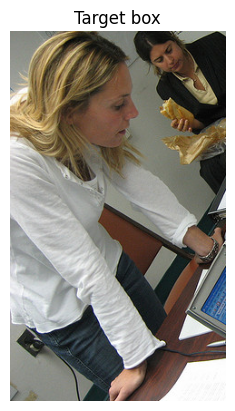

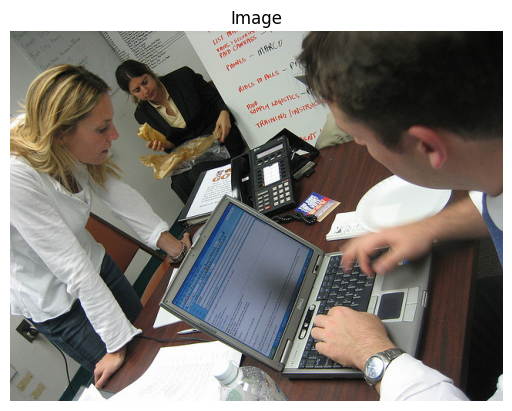

In [23]:
# show an example of the crop

print('Caption: ',train_dataset[0]['caption'])


x_min = int(train_dataset[0]['bbox'][0])
x_max = x_min + int(train_dataset[0]['bbox'][2])

y_min = int(train_dataset[0]['bbox'][1])
y_max = y_min + int(train_dataset[0]['bbox'][3])

plt.imshow(plt.imread(train_dataset[0]['file_name'])[y_min:y_max,x_min:x_max])
plt.title('Target box')
plt.axis('off')

plt.figure()

plt.imshow(plt.imread(train_dataset[0]['file_name']))
plt.title('Image')
plt.axis('off')

In [31]:
import matplotlib.pyplot as plt

def bring_crop(f_name, box, display = False):

  x_min = int(box[0])
  x_max = x_min + int(box[2])

  y_min = int(box[1])
  y_max = y_min + int(box[3])

  if display:
    # plot the box
    plt.imshow(plt.imread(f_name)[y_min:y_max,x_min:x_max])
    plt.title('Target box')
    plt.axis('off')
    return None
  
  return plt.imread(f_name)[y_min:y_max,x_min:x_max]

In [23]:
# experiments with yolos

In [ ]:
!pip install transformers

In [13]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests

url = train_dataset[0]['file_name']
image = Image.open(url)

image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.3 MB/s eta 0:00:00


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected person with confidence 0.987 at location [383.42, 1.31, 639.86, 475.17]
Detected person with confidence 0.906 at location [0.37, 43.95, 250.66, 473.23]
Detected person with confidence 0.91 at location [0.37, 44.26, 233.26, 471.98]
Detected book with confidence 0.934 at location [375.51, 209.56, 436.31, 252.72]
Detected clock with confidence 0.945 at location [467.14, 421.48, 495.12, 453.69]
Detected person with confidence 0.98 at location [142.36, 38.31, 309.41, 232.33]
Detected laptop with confidence 0.994 at location [193.09, 211.71, 472.76, 449.58]


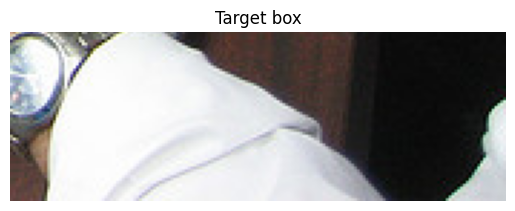

In [32]:
# Detected clock with confidence 0.945 at location [467.14, 421.48, 495.12, 453.69]
# yolos is not precise
bring_crop(url, [467.14, 421.48, 495.12, 453.69], display = True)

In [33]:
# load detr

In [4]:
import torch
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [5]:
# source: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=Y6Jrz6xz71C0
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [6]:
# first image
from PIL import Image


f_name = train_dataset[0]['file_name']
im = Image.open(f_name)

scores, boxes = detect(im, model, transform)

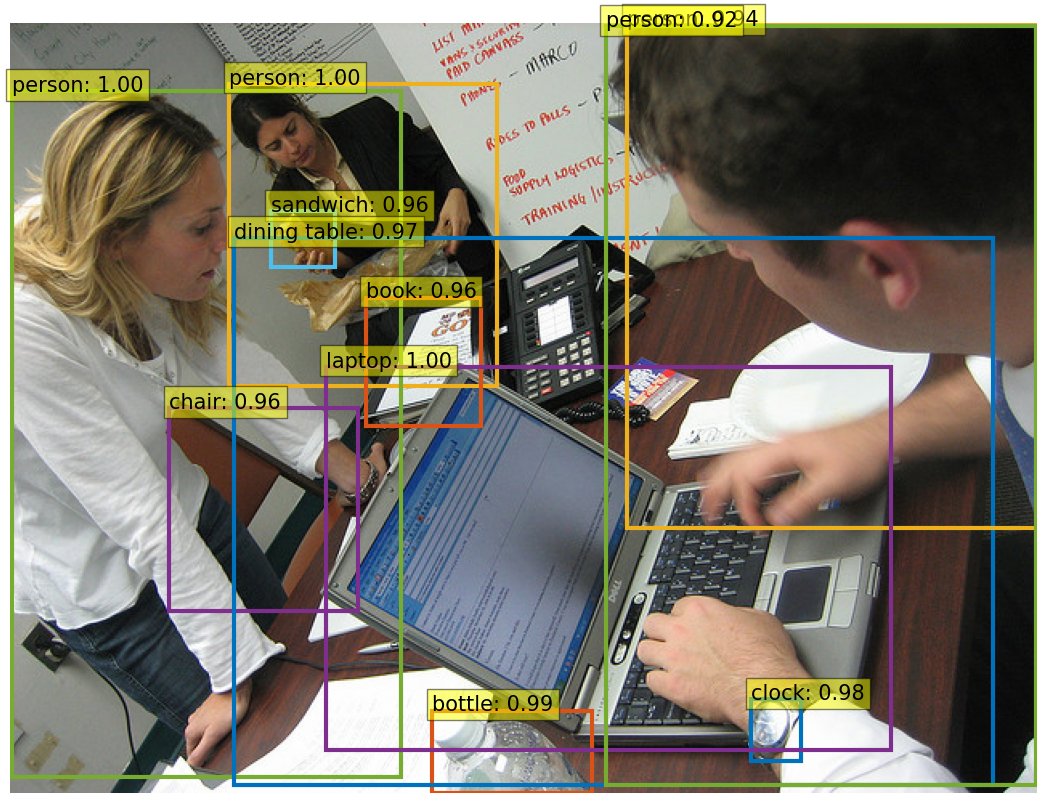

In [7]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)

# here we show the evindece of how much detr is precise 
# compared to yolo

In [8]:
import matplotlib.pyplot as plt

def bring_crop(f_name, box, display = False):

  x_min, y_min, x_max, y_max = box.tolist()

  if display:
    # plot the box
    plt.figure()
    plt.imshow(plt.imread(f_name)[int(y_min):int(y_max),int(x_min):int(x_max)])
    plt.title('Target box')
    plt.axis('off')
    return None
  
  return plt.imread(f_name)[int(y_min):int(y_max),int(x_min):int(x_max)]

In [9]:
boxes_found_detr = [bring_crop(f_name, b) for b in boxes]
print('number of boxes found: ',len(boxes_found_detr))

number of boxes found:  11


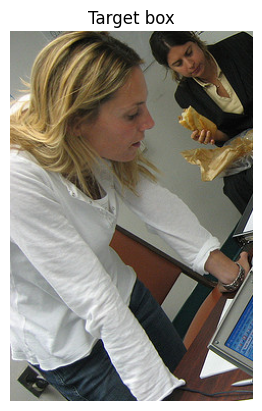

In [29]:
bring_crop('.'+f_name, np.array([0.0,45.95,238.92,408.64]), display = True)

In [17]:
# install clip dependencies
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-i5ynx_0a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-i5ynx_0a
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=22777ea989908c810b2fdacbbe8d60e941b93e3fc98637a72dc435721f420ceb
  Stored in directory: /tmp/pip-ephem-wheel-cache-abh2j761/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip
ERROR: Operation cancelled by user


In [41]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'BLIP'...
remote: Enumerating objects: 274, done.
remote: Total 274 (delta 0), reused 0 (delta 0), pack-reused 274
Receiving objects: 100% (274/274), 7.16 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/content/BLIP


In [45]:
# %cd ..
# !rm -rf ./BLIP
# !pwd

/content
/content


In [30]:
import sys
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image,device = 'cuda'):
    raw_image = Image.fromarray(np.uint8(image)).convert('RGB')  
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    
    image = transform(raw_image).unsqueeze(0).to(device) 
      
    return image, raw_image

In [ ]:
# use blip to produce the caption for each box
from models.blip import blip_decoder
# i don't know why here do not work
# on my notebook work

In [10]:
del model
!pip install salesforce-lavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
import numpy as np

In [12]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, vis_processors, _ = load_model_and_preprocess(
    name="blip_caption", model_type="large_coco", is_eval=True, device=device
)

def load_image(image):
    return Image.fromarray(np.uint8(image)).convert('RGB')  

im_detr_boxes = [load_image(i) for i in boxes_found_detr]



In [13]:
images_preprocessed = [vis_processors["eval"](i).unsqueeze(0).to(device) for i in im_detr_boxes]
caption_detr_boxes = [model.generate({"image": i}, use_nucleus_sampling=True, num_captions=10) for i in images_preprocessed]

In [14]:
# bring_crop(f_name, np.array(boxes[9]), display = True)
del model
caption_detr_boxes

[['a hand holding a watch with the display',
  'a person is holding a wrist watch on their right hand',
  "a man's wrist with a watch on it",
  'the man has a blue and white watch on his wrist',
  'a person wearing a watch while another watches on them',
  'a person holding a watch that is sitting on top of their hand',
  'this watch is made of blue and silver material',
  'an unidentifiable person showing off a metal watch',
  'a close up of a wrist with a watch',
  "the hand is holding up a watch and it's dials"],
 ['a toothbrush sits beside a container full of water',
  'an image of a close up of a bottle with liquid in it',
  'a container holding two bottles of water',
  'a white toothbrush on a glass holder next to a mirror',
  'there is a picture of someone standing near the sink',
  'a bottle filled with water sitting next to a microwave',
  'a glass filled with a large bottle next to a mirror',
  'a glass container filled with toothbrushes next to a wall mounted microwave',
  '

In [15]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [16]:
# !pip uninstall clip -y
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qvf3o2dt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qvf3o2dt
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [50]:
# encode the sentences with clip
import torch
import clip
from PIL import Image

probabilities = []
encoding_text_features = []
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load the model
model, preprocess = clip.load("ViT-B/32", device=device)

# Preprocess an image
image = preprocess(Image.open(f_name)).unsqueeze(0).to(device)
# Preprocess a text
for b in caption_detr_boxes:
  sent = []
  for i in b:
    sent.append(i)
  sent.append(train_dataset[0]['caption'])
  text = clip.tokenize(sent).to(device)

  # Compute logits
  with torch.no_grad():
      image_features = model.encode_image(image)
      text_features = model.encode_text(text)
      
      logits_per_image, logits_per_text = model(image, text)
      probs = logits_per_image.softmax(dim=-1).cpu().numpy()

  probabilities.append(probs)
  encoding_text_features.append(text_features)

''' Observation:
the evidence shows that the encoding of really accurate caption 
get the highest probability of the correct label (image).
'''
print("Label probs:", probabilities) 

Label probs: [array([[2.376e-04, 6.356e-04, 5.960e-06, 3.940e-05, 3.049e-04, 1.425e-05,
        6.557e-07, 2.283e-05, 1.371e-06, 5.305e-06, 9.985e-01]],
      dtype=float16), array([[1.729e-06, 3.576e-07, 1.645e-05, 2.027e-06, 2.503e-06, 4.172e-07,
        5.841e-06, 1.669e-06, 9.537e-07, 1.371e-06, 1.000e+00]],
      dtype=float16), array([[1.050e-04, 2.056e-04, 1.028e-03, 9.298e-06, 1.245e-01, 4.172e-06,
        6.199e-03, 2.957e-02, 4.220e-04, 1.328e-04, 8.379e-01]],
      dtype=float16), array([[5.317e-05, 2.383e-04, 2.537e-04, 7.889e-03, 2.903e-03, 2.676e-05,
        8.345e-07, 2.383e-04, 1.782e-05, 2.090e-03, 9.863e-01]],
      dtype=float16), array([[0.141   , 0.04437 , 0.001518, 0.1388  , 0.014404, 0.000728,
        0.1324  , 0.2184  , 0.01232 , 0.07086 , 0.2252  ]], dtype=float16), array([[6.735e-06, 1.309e-04, 7.300e-04, 1.223e-03, 2.921e-05, 1.967e-06,
        4.716e-04, 8.345e-06, 7.534e-04, 1.913e-05, 9.966e-01]],
      dtype=float16), array([[0.001847, 0.0947  , 0.003094,

In [57]:
def caption_clip_encoding(caption_detr_boxes, target_caption):

  encoding_text_features = []

  text = clip.tokenize(target_caption).to(device)
  text_features = model.encode_text(text)
  encoding_text_features.append(text_features)

  for i in caption_detr_boxes:
    temp = []
    for j in i:
      text = clip.tokenize(j).to(device)
      with torch.no_grad():
        text_features = model.encode_text(text)
      
      temp.append(text_features)

    encoding_text_features.append(temp)

  return encoding_text_features
  

<Axes: title={'center': 'heatmap sentences'}>

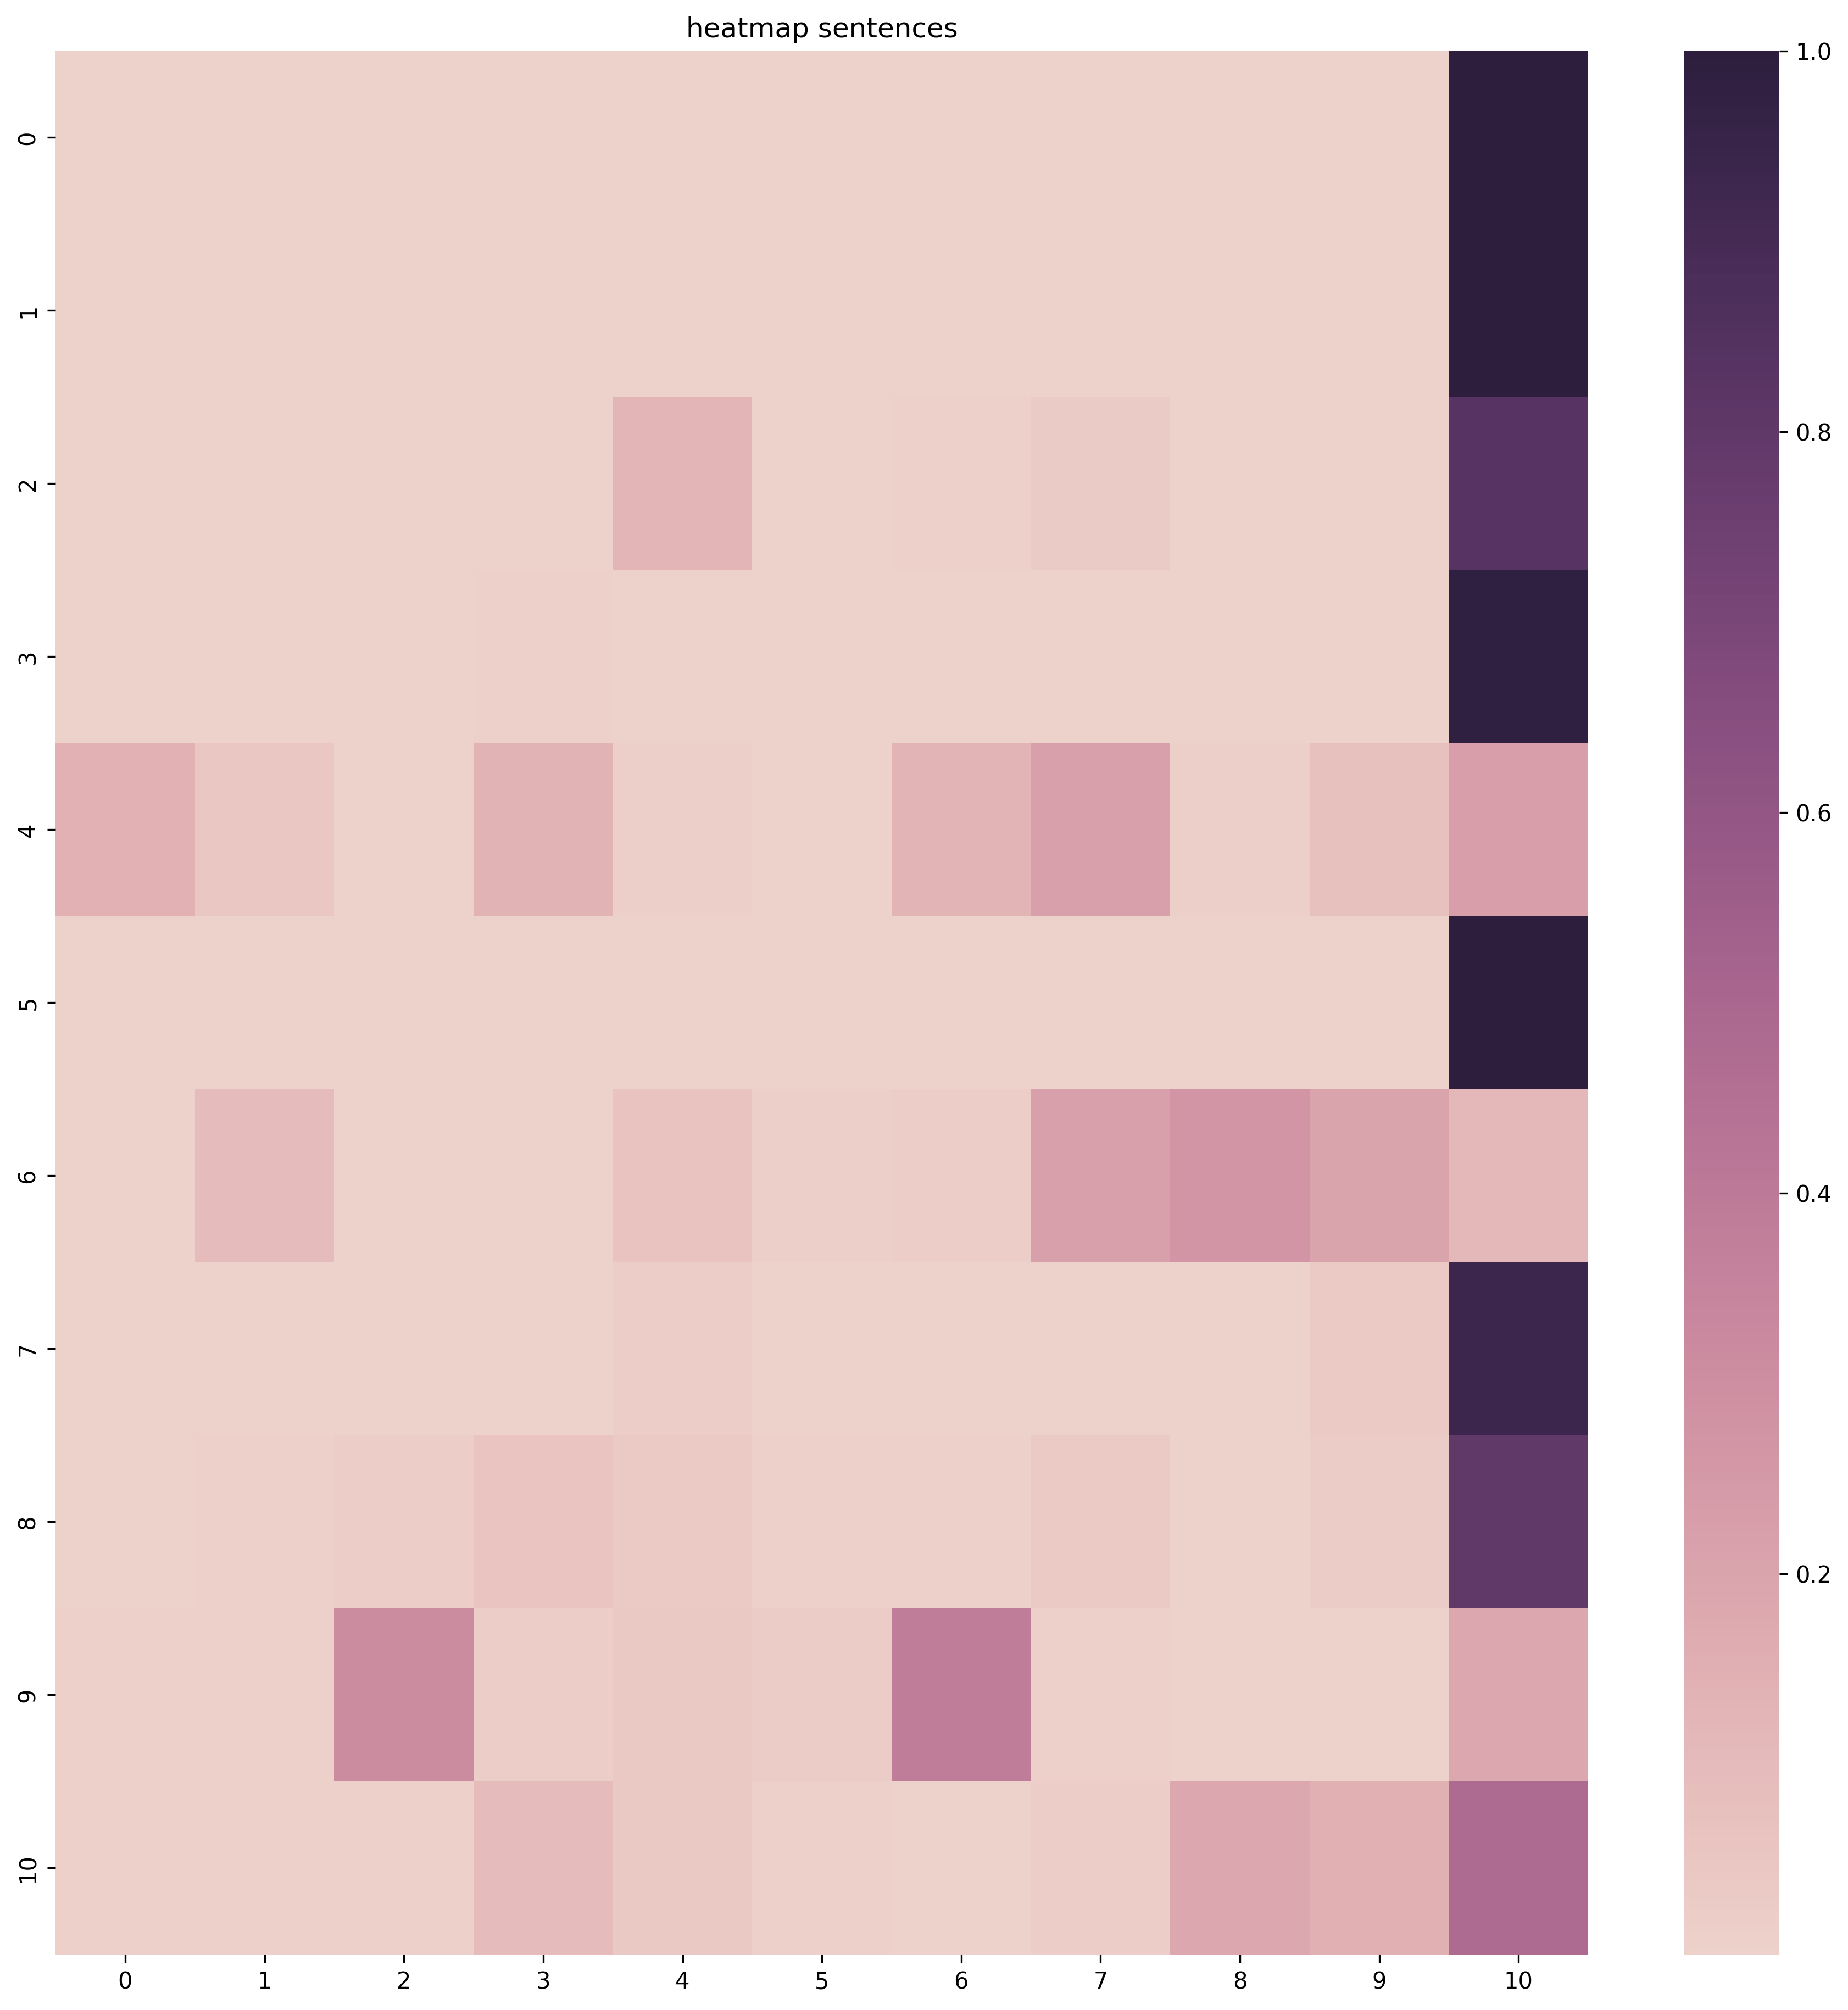

In [37]:
import seaborn as sns
p = [i.reshape(probabilities[0].shape[1]) for i in probabilities]
plt.figure(figsize=(15,15),dpi=300)
plt.title('heatmap sentences')
sns.heatmap(p, cmap=sns.cubehelix_palette(as_cmap=True))

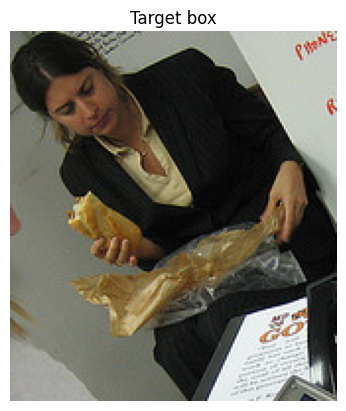

In [48]:
bring_crop(f_name,boxes[2],display=True)

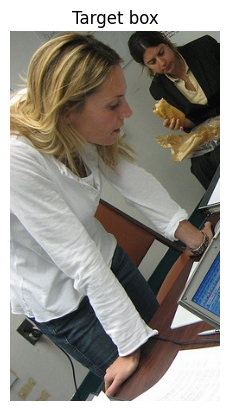

In [49]:
bring_crop(f_name,boxes[4],display=True)


In [58]:
# encode the text in the clip latent space
clip_encoded_caption = caption_clip_encoding(caption_detr_boxes, train_dataset[0]['caption'])

In [73]:
import numpy as np
import torch

# compute the metrics

""" I think that with those metrics we can mesure the distance the 
    distances between the encoded caption and the target label.

    Encoding the metrics as a vector I can easily identify with 
    a simple linear layer a try to find the best weights for weighting 
    each metric. Maybe I think that there are metrics that are more
    important than others. Specifically I think that the score in output
    score identifies the best box.

"""

def euclidean_distance(u, v):
    """Computes the euclidean distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: euclidean distance between the two sets of items
    """
    return torch.sqrt(torch.sum((u - v) ** 2))

def cosine_similarity(u, v):
    """Computes the cosine similarity between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:    
        float: cosine similarity between the two sets of items

    """
    return torch.dot(u, v).cpu() / (torch.linalg.norm(u) * torch.linalg.norm(v))

# Jaccard similarity
# source: https://www.learndatasci.com/glossary/jaccard-similarity/
def jaccard_similarity(u, v):
    """Computes the Jaccard similarity between two sets of items.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: Jaccard similarity between the two sets of items

    """
    intersection = len(set(u).intersection(set(v)))
    union = len(set(u).union(set(v)))
    return intersection / union

def pearson_correlation(u, v):
    """Computes the Pearson correlation between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: Pearson correlation between the two sets of items
    """
    return np.corrcoef(u.cpu(), v.cpu())[0, 1]

def manhattan_distance(u, v):
    """Computes the Manhattan distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: Manhattan distance between the two sets of items

    """
    return torch.sum(torch.abs(u - v))

def minkowski_distance(u, v, p):
    """Computes the Minkowski distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items
        p (int): order of the norm

    Returns:
        float: Minkowski distance between the two sets of items

    Note: When p=1, the distance is the Manhattan distance, and 
    when p=2, the distance is the Euclidean distance.
    """
    return torch.sum(torch.abs(u - v) ** p) ** (1/p)

print('Sentences encoded in the latent space: ',text_features.shape)

# compute the distance between the tokenized caption and the image
# the distance is computed between the two vectors of the same dimension


dictionary = dict()

for idx,i in enumerate(clip_encoded_caption[1:]):
  print()
  print()
  print('box: ',idx)
  print()
  print()

  euclidean=[]
  cosine=[]
  pearson=[]
  manhattan=[]
  minkowski=[]

  for j in i:

    euclidean.append(float(euclidean_distance(clip_encoded_caption[0].reshape(512),j.reshape(512))))
    cosine.append(cosine_similarity(clip_encoded_caption[0].reshape(512),j.reshape(512)))
    pearson.append(pearson_correlation(clip_encoded_caption[0].reshape(512),j.reshape(512)))
    manhattan.append(float(manhattan_distance(clip_encoded_caption[0].reshape(512),j.reshape(512))))
    minkowski.append(float(minkowski_distance(clip_encoded_caption[0].reshape(512),j.reshape(512),4)))

    print('Euclidean distance: ',float(euclidean_distance(clip_encoded_caption[0].reshape(512),j.reshape(512))))
    print('Cosine similarity: ',float(cosine_similarity(clip_encoded_caption[0].reshape(512),j.reshape(512))))
    # print('Jaccard similarity: ',float(jaccard_similarity(text_features[0].reshape(512),text_features[1].reshape(512)))) # no sense in this context
    print('Pearson correlation: ',pearson_correlation(clip_encoded_caption[0].reshape(512),j.reshape(512)))
    print('Manhattan distance: ',float(manhattan_distance(clip_encoded_caption[0].reshape(512),j.reshape(512))))
    print('Minkowski distance: ',float(minkowski_distance(clip_encoded_caption[0].reshape(512),j.reshape(512),4)),'p: ',4)
  
  temp = dict()
  temp['Euclidean'] = np.array(euclidean)
  temp['Cosine'] = np.array(torch.Tensor(cosine).cpu())
  temp['Pearson'] = np.array(pearson)
  temp['Manhattan'] = np.array(manhattan)
  temp['Minkowski'] = np.array(minkowski)

  dictionary[idx] = temp



Sentences encoded in the latent space:  torch.Size([11, 512])


box:  0


Euclidean distance:  7.4921875
Cosine similarity:  0.59033203125
Pearson correlation:  0.5901138260510113
Manhattan distance:  135.75
Minkowski distance:  2.060546875 p:  4
Euclidean distance:  7.375
Cosine similarity:  0.63525390625
Pearson correlation:  0.6339372006926818
Manhattan distance:  132.5
Minkowski distance:  2.0625 p:  4
Euclidean distance:  7.72265625
Cosine similarity:  0.61669921875
Pearson correlation:  0.615928065019946
Manhattan distance:  135.25
Minkowski distance:  2.2421875 p:  4
Euclidean distance:  8.015625
Cosine similarity:  0.63623046875
Pearson correlation:  0.63546910666084
Manhattan distance:  139.5
Minkowski distance:  2.751953125 p:  4
Euclidean distance:  6.82421875
Cosine similarity:  0.68603515625
Pearson correlation:  0.6853796022539298
Manhattan distance:  123.625
Minkowski distance:  1.8662109375 p:  4
Euclidean distance:  7.5859375
Cosine similarity:  0.59130859375
Pearson c

In [80]:

min_d = dict()

for k in dictionary.keys():
  print()
  temp = dict()
  for kk in dictionary[0].keys():
    if kk == 'Euclidean':
      print('box: ',k,' min ',kk,': ', dictionary[k][kk].min())
      temp[kk] = dictionary[k][kk].min()
    else:
      print('box: ',k,' mean ',kk,': ', dictionary[k][kk].mean())
      temp[kk] = dictionary[k][kk].mean()

  min_d[k] = temp


box:  0  min  Euclidean :  6.82421875
box:  0  mean  Cosine :  0.60898435
box:  0  mean  Pearson :  0.608382883355657
box:  0  mean  Manhattan :  136.3875
box:  0  mean  Minkowski :  2.28408203125

box:  1  min  Euclidean :  7.22265625
box:  1  mean  Cosine :  0.56879884
box:  1  mean  Pearson :  0.5681253740380134
box:  1  mean  Manhattan :  136.125
box:  1  mean  Minkowski :  2.17265625

box:  2  min  Euclidean :  5.6015625
box:  2  mean  Cosine :  0.6994629
box:  2  mean  Pearson :  0.6980481986327108
box:  2  mean  Manhattan :  113.54375
box:  2  mean  Minkowski :  1.80126953125

box:  3  min  Euclidean :  6.66015625
box:  3  mean  Cosine :  0.62954104
box:  3  mean  Pearson :  0.6282336217039332
box:  3  mean  Manhattan :  127.15
box:  3  mean  Minkowski :  2.106640625

box:  4  min  Euclidean :  5.28125
box:  4  mean  Cosine :  0.7212402
box:  4  mean  Pearson :  0.7211674789230793
box:  4  mean  Manhattan :  109.4
box:  4  mean  Minkowski :  1.81611328125

box:  5  min  Euclide

In [82]:
import pandas as pd

pd.DataFrame(min_d).sort_values(by=['Euclidean'], axis=1)
# the best box given the blip caption is the right one

4           5           2           6           7   \
Euclidean    5.281250    5.429688    5.601562    5.710938    5.839844   
Cosine       0.721240    0.688770    0.699463    0.700635    0.600635   
Pearson      0.721167    0.687023    0.698048    0.700538    0.600982   
Manhattan  109.400000  120.943750  113.543750  112.756250  129.025000   
Minkowski    1.816113    2.258594    1.801270    1.863672    2.075293   

                   9           10          8           3           0   \
Euclidean    5.839844    5.875000    6.269531    6.660156    6.824219   
Cosine       0.678125    0.689062    0.678369    0.629541    0.608984   
Pearson      0.677391    0.688440    0.677600    0.628234    0.608383   
Manhattan  116.425000  114.775000  118.425000  127.150000  136.387500   
Minkowski    1.968262    1.928418    1.996777    2.106641    2.284082   

                   1   
Euclidean    7.222656  
Cosine       0.568799  
Pearson      0.568125  
Manhattan  136.125000  
Minkowski    2.172656

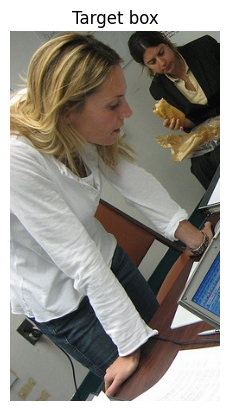

In [83]:
bring_crop(f_name,boxes[4],display=True)

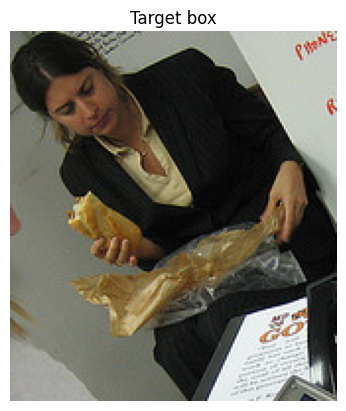

In [86]:
bring_crop(f_name,boxes[2],display=True)